Notebook for running scripts in the simclr-pytorch repo on Google Colab

In [10]:
# Mount google drive
from google.colab import drive
ROOT = "/content/drive"
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)

/content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# cd to /Repo
%cd drive/MyDrive/Repos/simclr-pytorch-cvf/
%pwd

/content/drive/MyDrive/Repos/simclr-pytorch-cvf


'/content/drive/MyDrive/Repos/simclr-pytorch-cvf'

In [3]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:27
🔁 Restarting kernel...


In [1]:
!conda --version

conda 22.9.0


In [2]:
%cd drive/MyDrive/Repos/simclr-pytorch-cvf/
!conda env create -f environment.yml

/content/drive/MyDrive/Repos/simclr-pytorch-cvf
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 22.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



wcwidth-0.2.5        | 29 KB     | : 100% 1.0/1 [00:00<00:00, 10.75it/s]
setuptools-51.0.0    | 712 KB    | : 100% 1.0/1 [00:01<00:00,  1.24s/it]
intel-openmp-2020.2  | 786 KB    | : 100% 1.0/1 [00:00<00:00, 18.61it/s]
ld_impl_linux-64-2.3 | 568 KB    | : 100% 1.0/1 [00:00<00:00, 20.84it/s]
scikit-learn-0.23.2  | 5.0 MB    | : 100% 1.0/1 [00:02<00:00,  2.90s/it]               
dataclasses-0.7      | 30 KB     | : 100% 1.0/1 [00:00<00:00,  2.63it/s]               
_libgcc_mutex-0.1    | 3 KB      | : 100% 1.0/1 [00:00<00:00, 46.14it/s]
yaml-0.2.5           | 75 KB     | : 100% 1.0/1 [00:00<00:00, 35.55it/s]
python-d

In [3]:
!conda env list

# conda environments:
#
base                     /usr/local
simclr_pytorch           /usr/local/envs/simclr_pytorch



In [ ]:
# run this in CLI 
!source activate /usr/local/envs/simclr_pytorch

In [ ]:
# run this in CLI for pre-training
# !python train.py --config configs/cifar_train_epochs60_bs256.yaml

# run this in CLI for linear classifier training
# python train.py --config configs/cifar_eval.yaml --encoder_ckpt logs/exman-train.py/runs/000004/checkpoint-12000.pth.tar


Traceback (most recent call last):
  File "train.py", line 5, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'


In [5]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from utils import datautils
import numpy as np
import PIL
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
#testset = datasets.CIFAR10(root train=False, download=True)
REPO_PATH = os.path.join(ROOT, "MyDrive/Repos/simclr-pytorch-cvf")

In [14]:
testset = datasets.CIFAR10(root=REPO_PATH, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Repos/simclr-pytorch-cvf/cifar-10-python.tar.gz to /content/drive/MyDrive/Repos/simclr-pytorch-cvf


In [15]:
len(testset)

10000

In [22]:
testset.data.shape

(10000, 32, 32, 3)

In [36]:
samp = testset.data[1]

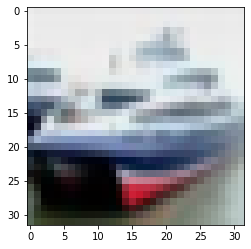

In [37]:
plt.imshow(samp)

In [41]:
def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    # given from https://arxiv.org/pdf/2002.05709.pdf
    color_jitter = transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = transforms.RandomApply([color_jitter], p=0.8)
    rnd_gray = transforms.RandomGrayscale(p=0.2)
    color_distort = transforms.Compose([
        rnd_color_jitter,
        rnd_gray])
    return color_distort

class Clip(object):
    def __call__(self, x):
        return torch.clamp(x, 0, 1)

In [44]:
# train_transform = transforms.Compose([
#                       transforms.RandomResizedCrop(
#                         32,
#                         scale=(self.hparams.scale_lower, 1.0),
#                         interpolation=PIL.Image.BICUBIC,
#                 ),
#                 transforms.RandomHorizontalFlip(),
#                 get_color_distortion(s=self.hparams.color_dist_s), #datautils.
#                 transforms.ToTensor(),
#                 Clip(), #datautils.
#             ])
# test_transform = train_transform
train_transform = transforms.Compose([
                      transforms.RandomResizedCrop(
                        32,
                        scale=(.08, 1.0),
                        interpolation=PIL.Image.BICUBIC,
                ),
                transforms.RandomHorizontalFlip(),
                get_color_distortion(s=1.), #datautils.
                transforms.ToTensor(),
                Clip(), #datautils.
            ])
test_transform = train_transform

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [60]:
test_transform

Compose(
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic), antialias=None)
    RandomHorizontalFlip(p=0.5)
    Compose(
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.19999999999999996, 1.8], contrast=[0.19999999999999996, 1.8], saturation=[0.19999999999999996, 1.8], hue=[-0.2, 0.2])
)
    RandomGrayscale(p=0.2)
)
    ToTensor()
)

In [62]:
trainset_aug = datasets.CIFAR10(root=REPO_PATH, train=True, download=True, transform=train_transform)

Files already downloaded and verified


In [47]:
testset.transform

In [48]:
testset.transforms

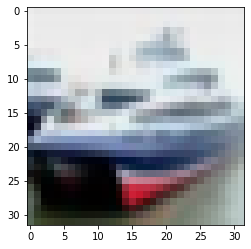

In [49]:
samp = testset.data[1]
plt.imshow(samp)

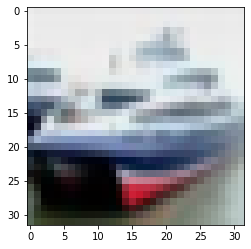

In [56]:
samp_aug = testset_aug.data[1]
plt.imshow(samp_aug)

In [52]:
testset_aug.transform

Compose(
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic), antialias=None)
    RandomHorizontalFlip(p=0.5)
    Compose(
    RandomApply(
    p=0.8
    ColorJitter(brightness=[0.19999999999999996, 1.8], contrast=[0.19999999999999996, 1.8], saturation=[0.19999999999999996, 1.8], hue=[-0.2, 0.2])
)
    RandomGrayscale(p=0.2)
)
    ToTensor()
)

In [63]:
testset.data.shape

(10000, 32, 32, 3)

In [54]:
testset_aug.transforms

StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic), antialias=None)
               RandomHorizontalFlip(p=0.5)
               Compose(
               RandomApply(
               p=0.8
               ColorJitter(brightness=[0.19999999999999996, 1.8], contrast=[0.19999999999999996, 1.8], saturation=[0.19999999999999996, 1.8], hue=[-0.2, 0.2])
           )
               RandomGrayscale(p=0.2)
           )
               ToTensor()
           )

In [59]:
# testset_aug.transforms(torch.tensor(samp_aug))

TypeError: ignored

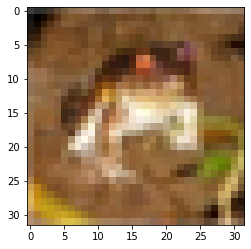

In [65]:
plt.imshow(trainset_aug.data[0])

In [66]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	augment_experiment.ipynb
	cifar-10-batches-py/
	cifar-10-python.tar.gz
	models/data/

nothing added to commit but untracked files present (use "git add" to track)
